In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoModel
import torch
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
parquet_file = "/content/drive/MyDrive/Colab Notebooks/Data/turkish_product_reviews.parquet"
df = pd.read_parquet(parquet_file)
df.head(10)

,sentence,sentiment
0,fena değil paraya göre iyi.,1
1,ürün kaliteli ve çok kullanışlı kargo ya veril...,1
2,fiyat-performans karşılaştırması yaptığınızda ...,1
3,bu fiyata çok iyi,1
4,fiyat ve performans olarak gayet iyi,1
5,i̇stenileni veriyor.,1
6,arzum super fön. daha oncede farkli markasini ...,1
7,hepsiburada.com,1
8,i̇yi,1
9,gayet iyi bi kac gun icinde geldi hizmet cok i...,1


In [ ]:
df.tail(10)

,sentence,sentiment
235155,i̇lk defa si̇zden aldiğim bi̇r şeyi̇ çok beğen...,0
235156,aldim ama hiç begenmedim sesi cıkmıyor elbise ...,0
235157,ürünü 2 yaşındaki kızım için aldım başı çok bü...,0
235158,ürün kaliteli fakat ebatı toyota corolla'da ço...,0
235159,ürün eli̇me geçti̇ hemen suyu doldurup açtim. ...,0
235160,odada bu buhar makinası çalışırken uyumak kesi...,0
235161,ürün gayet güzel ve sağlam.tek kusuru sesli ça...,0
235162,hepsiburadaya tesekkurler,0
235163,çok ufak ve basit plastikten yapılmış. hiç kul...,0
235164,fotoğrafta göründüğü gibi değil. i̇nce ve kesi...,0


In [ ]:
texts = df['sentence']
labels = df['sentiment']

In [ ]:
group_1 = df[df['sentiment'] == 1].sample(n=2500, random_state=42)
group_0 = df[df['sentiment'] == 0].sample(n=2500, random_state=42)

balanced_df = pd.concat([group_1, group_0])

In [ ]:
train_df, test_df = train_test_split(
    balanced_df,
    test_size=0.2,
    random_state=42,
    stratify=balanced_df['sentiment'] #Ensures the distribution of 'sentiment' is preserved across train and test sets
)

In [ ]:
len_train = len(train_df)
len_test = len(test_df)

train_class_distribution = train_df['sentiment'].value_counts()
test_class_distribution = test_df['sentiment'].value_counts()

print(f"Train Dist: {train_class_distribution}, \n\nTest Dist: {test_class_distribution}, \n\nLEN: {len_train, len_test} \n\n")


Train Dist: sentiment
1    2000
0    2000
Name: count, dtype: int64, 

Test Dist: sentiment
0    500
1    500
Name: count, dtype: int64, 

LEN: (4000, 1000) 




In [ ]:
embedding_models = {
    "bert": "dbmdz/bert-base-turkish-uncased",
    "minilm": "sentence-transformers/all-MiniLM-L12-v2",
    "gte": "thenlper/gte-large",
    "jina": "jinaai/jina-embeddings-v3",
    "bge": "BAAI/bge-m3"
}

In [ ]:
classifiers = {
    "SVM": SVC(probability=True),
    "RF": RandomForestClassifier(),
    "MLP": MLPClassifier()
}

In [ ]:
import os

# Function to save embeddings as a .npy file
def save_embeddings(embeddings, file_name):
    np.save(file_name, embeddings)

# Function to load embeddings from a .npy file
def load_embeddings(file_name):
    return np.load(file_name)

In [ ]:
device = torch.device("cuda")

# Function to generate embeddings from a text list using a pre-trained language model
def get_embeddings(texts, model_name, batch_size=32, max_length=512):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    model.eval()

    embeddings = []
    for i in range(0, len(texts), batch_size): # Process the input texts in batches
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(
            list(batch_texts),
            padding=True,
            truncation=True, # Truncate sequences longer than max_length
            max_length=max_length,
            return_tensors="pt" # Return PyTorch tensors
        ).to(device)
        with torch.no_grad(): # Disable gradient computation to save memory
            outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).cpu().type(torch.float32).numpy()) # Compute mean embeddings across the sequence dimension (dim=1)
    return np.vstack(embeddings)

# Function to generate embeddings and save them to a file
def get_embeddings_and_save(texts, model_name, output_file, batch_size=32):
    embeddings = get_embeddings(texts, model_name, batch_size=batch_size)

    save_embeddings(embeddings, output_file)

    return embeddings


In [ ]:
# Initialize a dictionary to store predictions for each embedding model and classifier
all_predictions = {model_key: {clf_name: [] for clf_name in classifiers.keys()} for model_key in embedding_models.keys()}

for model_key, model_name in embedding_models.items():
    print(f"Processing embeddings for {model_name}...")

    train_file = f"{model_key}_train_embeddings.npy"
    test_file = f"{model_key}_test_embeddings.npy"

    # Check if embeddings exist; if not, generate and save them   
    if not os.path.exists(train_file):
        train_embeddings = get_embeddings_and_save(train_df['sentence'], model_name, train_file)
    else:
        train_embeddings = load_embeddings(train_file)

    if not os.path.exists(test_file):
        test_embeddings = get_embeddings_and_save(test_df['sentence'], model_name, test_file)
    else:
        test_embeddings = load_embeddings(test_file)

    for clf_name, clf in classifiers.items(): # Loop through each classifier (SVM, RF, MLP)
        print(f"Training {clf_name} with {model_name} embeddings...")

        clf.fit(train_embeddings, train_df['sentiment'])
        predictions = clf.predict(test_embeddings)
        all_predictions[model_key][clf_name] = predictions # Store the predictions in the dictionary


Processing embeddings for dbmdz/bert-base-turkish-uncased...
Training SVM with dbmdz/bert-base-turkish-uncased embeddings...
Training RF with dbmdz/bert-base-turkish-uncased embeddings...
Training MLP with dbmdz/bert-base-turkish-uncased embeddings...
Processing embeddings for sentence-transformers/all-MiniLM-L12-v2...
Training SVM with sentence-transformers/all-MiniLM-L12-v2 embeddings...
Training RF with sentence-transformers/all-MiniLM-L12-v2 embeddings...
Training MLP with sentence-transformers/all-MiniLM-L12-v2 embeddings...


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Processing embeddings for thenlper/gte-large...
Training SVM with thenlper/gte-large embeddings...
Training RF with thenlper/gte-large embeddings...
Training MLP with thenlper/gte-large embeddings...


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Processing embeddings for jinaai/jina-embeddings-v3...
The repository for jinaai/jina-embeddings-v3 contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/jinaai/jina-embeddings-v3.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for jinaai/jina-embeddings-v3 contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/jinaai/jina-embeddings-v3.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Training SVM with jinaai/jina-embeddings-v3 embeddings...
Training RF with jinaai/jina-embeddings-v3 embeddings...
Training MLP with jinaai/jina-embeddings-v3 embeddings...
Processing embeddings for BAAI/bge-m3...


tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

Training SVM with BAAI/bge-m3 embeddings...
Training RF with BAAI/bge-m3 embeddings...
Training MLP with BAAI/bge-m3 embeddings...


In [ ]:
representation_ensembles = {} # Dictionary to store ensemble predictions for each embedding model

for model_key in embedding_models.keys():
    ensemble_predictions = []
    for i in range(len(test_df)):
        
        # Collect predictions from all classifiers (SVM, RF, MLP) for the current test sample
        votes = [all_predictions[model_key][clf_name][i] for clf_name in classifiers.keys()]
        # Majority vote
        majority_vote = Counter(votes).most_common(1)[0][0]
        ensemble_predictions.append(majority_vote)
    representation_ensembles[model_key] = ensemble_predictions

In [ ]:
algorithm_ensembles = {} # Dictionary to store ensemble predictions for each classifier

for clf_name in classifiers.keys():
    ensemble_predictions = []
    for i in range(len(test_df)):
        # Collect predictions from all embedding models for the current test sample
        votes = [all_predictions[model_key][clf_name][i] for model_key in embedding_models.keys()]
        
        # Majority vote
        majority_vote = Counter(votes).most_common(1)[0][0]
        ensemble_predictions.append(majority_vote)
    algorithm_ensembles[clf_name] = ensemble_predictions

In [ ]:
final_ensemble_predictions = []
for i in range(len(test_df)):
     # Collect predictions from all embedding models and all classifiers for the current test sample
    votes = [ 
        all_predictions[model_key][clf_name][i]
        for model_key in embedding_models.keys()
        for clf_name in classifiers.keys()
    ]
    # Majority vote
    majority_vote = Counter(votes).most_common(1)[0][0]
    final_ensemble_predictions.append(majority_vote)


In [ ]:
results_df = test_df.copy()
for model_key in embedding_models.keys():
    for clf_name in classifiers.keys():
        column_name = f"{model_key}_{clf_name}_prediction"
        results_df[column_name] = all_predictions[model_key][clf_name]

In [ ]:
# Add ensemble predictions for each embedding model to the results DataFrame
for model_key in embedding_models.keys():
    results_df[f"{model_key}_ensemble"] = representation_ensembles[model_key]

# Add ensemble predictions for each classifier to the results DataFrame
for clf_name in classifiers.keys():
    results_df[f"{clf_name}_ensemble"] = algorithm_ensembles[clf_name]
results_df["final_ensemble"] = final_ensemble_predictions

In [ ]:
representation_f1_scores = {
    model_key: f1_score(test_df['sentiment'], representation_ensembles[model_key], average="weighted")
    for model_key in embedding_models.keys()
}
algorithm_f1_scores = {
    clf_name: f1_score(test_df['sentiment'], algorithm_ensembles[clf_name], average="weighted")
    for clf_name in classifiers.keys()
}
final_ensemble_f1_score = f1_score(test_df['sentiment'], final_ensemble_predictions, average="weighted")

In [ ]:
individual_scores = []

for model_key in embedding_models.keys():
    for clf_name in classifiers.keys():
        y_true = test_df['sentiment']
        y_pred = all_predictions[model_key][clf_name]

        f1 = f1_score(y_true, y_pred, average="weighted")
        accuracy = accuracy_score(y_true, y_pred)

        individual_scores.append({
            "Model": model_key,
            "Classifier": clf_name,
            "F1 Score": f1,
            "Accuracy": accuracy
        })

individual_scores_df = pd.DataFrame(individual_scores)

print("\n--- Individual Model Results ---")
print(individual_scores_df)

individual_scores_df.to_csv("individual_model_results.csv", index=False)


In [ ]:
print("\n--- Results ---")
print("Representation Ensembles F1 Scores:", representation_f1_scores)
print("Algorithm Ensembles F1 Scores:", algorithm_f1_scores)
print("Final Ensemble F1 Score:", final_ensemble_f1_score)


--- Results ---
Representation Ensembles F1 Scores: {'bert': 0.8649404387334814, 'minilm': 0.7397960000640502, 'gte': 0.7334359504711971, 'jina': 0.8819957518470665, 'bge': 0.8829905222323009}
Algorithm Ensembles F1 Scores: {'SVM': 0.8849998849998851, 'RF': 0.8608094481344961, 'MLP': 0.8799980799692794}
Final Ensemble F1 Score: 0.8849906842454239


In [ ]:
results_df.head()

,sentence,sentiment,bert_SVM_prediction,bert_RF_prediction,bert_MLP_prediction,minilm_SVM_prediction,minilm_RF_prediction,minilm_MLP_prediction,gte_SVM_prediction,gte_RF_prediction,...,bge_MLP_prediction,bert_ensemble,minilm_ensemble,gte_ensemble,jina_ensemble,bge_ensemble,SVM_ensemble,RF_ensemble,MLP_ensemble,final_ensemble
226460,uyandıgımda burnumda olmuyor ...burnu iyide aç...,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4613,bu fiyata bu ürünlerin tamamını almak normalde...,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
227709,ürünü yorumlara bakarak aldım ancak tablet ve ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114505,fiyat olarak birşey söylemek zor. marka olarak...,1,0,0,0,0,0,1,1,0,...,0,0,0,1,1,1,1,0,1,1
44413,ürün bugün elime geçti. kurulumu 15 dakika gib...,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
results_df.to_csv("results.csv")

In [ ]:
from sklearn.metrics import accuracy_score


In [ ]:
representation_accuracy_scores = {
    model_key: accuracy_score(test_df['sentiment'], representation_ensembles[model_key])
    for model_key in embedding_models.keys()
}
algorithm_accuracy_scores = {
    clf_name: accuracy_score(test_df['sentiment'], algorithm_ensembles[clf_name])
    for clf_name in classifiers.keys()
}
final_ensemble_accuracy_score = accuracy_score(test_df['sentiment'], final_ensemble_predictions)

print("\n--- Results ---")
print("Representation Ensembles F1 Scores:", representation_f1_scores)
print("Representation Ensembles Accuracy Scores:", representation_accuracy_scores)

print("\nAlgorithm Ensembles F1 Scores:", algorithm_f1_scores)
print("Algorithm Ensembles Accuracy Scores:", algorithm_accuracy_scores)

print("\nFinal Ensemble F1 Score:", final_ensemble_f1_score)
print("Final Ensemble Accuracy Score:", final_ensemble_accuracy_score)



--- Results ---
Representation Ensembles F1 Scores: {'bert': 0.8649404387334814, 'minilm': 0.7397960000640502, 'gte': 0.7334359504711971, 'jina': 0.8819957518470665, 'bge': 0.8829905222323009}
Representation Ensembles Accuracy Scores: {'bert': 0.865, 'minilm': 0.74, 'gte': 0.734, 'jina': 0.882, 'bge': 0.883}

Algorithm Ensembles F1 Scores: {'SVM': 0.8849998849998851, 'RF': 0.8608094481344961, 'MLP': 0.8799980799692794}
Algorithm Ensembles Accuracy Scores: {'SVM': 0.885, 'RF': 0.861, 'MLP': 0.88}

Final Ensemble F1 Score: 0.8849906842454239
Final Ensemble Accuracy Score: 0.885


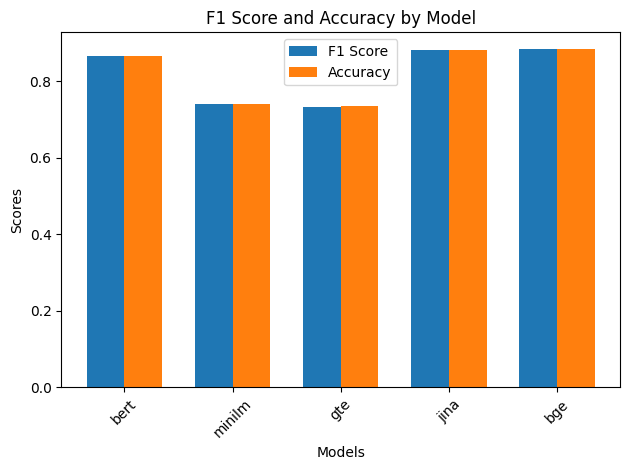

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = list(representation_f1_scores.keys())
f1_scores = list(representation_f1_scores.values())
accuracy_scores = list(representation_accuracy_scores.values())

x = np.arange(len(models))  
width = 0.35  

fig, ax = plt.subplots()
ax.bar(x - width/2, f1_scores, width, label='F1 Score')
ax.bar(x + width/2, accuracy_scores, width, label='Accuracy')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('F1 Score and Accuracy by Model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


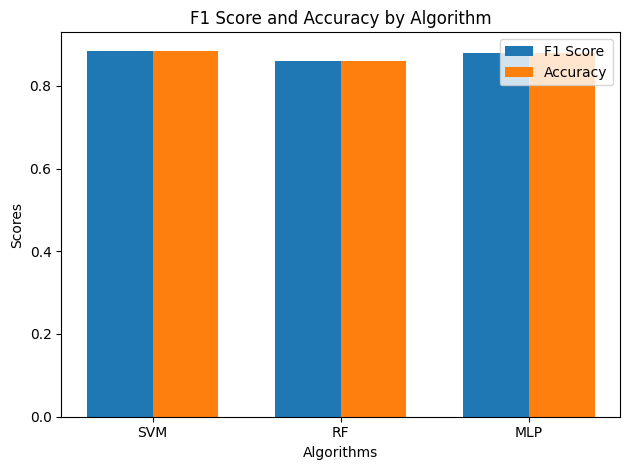

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

algorithms = list(algorithm_f1_scores.keys())
f1_scores = list(algorithm_f1_scores.values())
accuracy_scores = list(algorithm_accuracy_scores.values())

x = np.arange(len(algorithms)) 
width = 0.35  

fig, ax = plt.subplots()
ax.bar(x - width/2, f1_scores, width, label='F1 Score')
ax.bar(x + width/2, accuracy_scores, width, label='Accuracy')

ax.set_xlabel('Algorithms')
ax.set_ylabel('Scores')
ax.set_title('F1 Score and Accuracy by Algorithm')
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.legend()

plt.tight_layout()
plt.show()


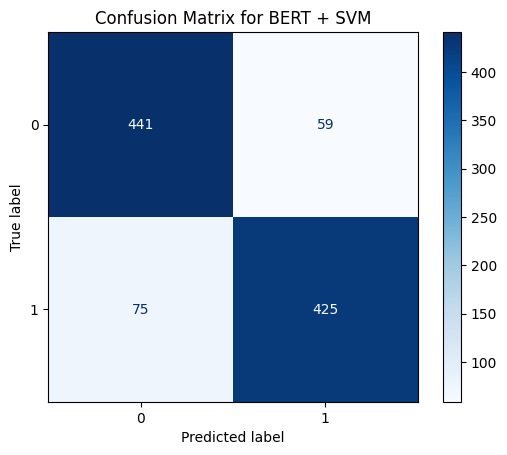

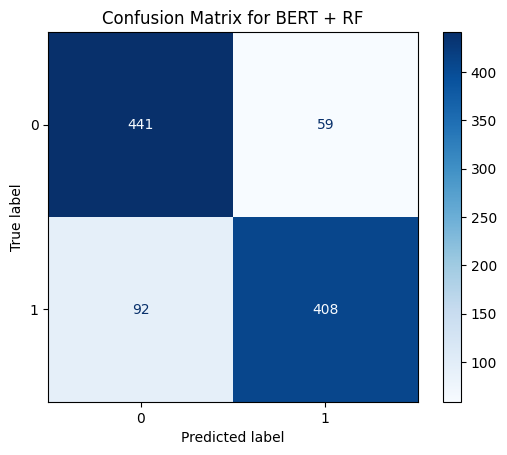

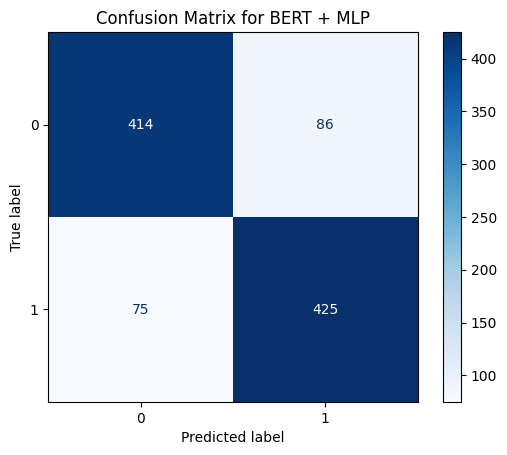

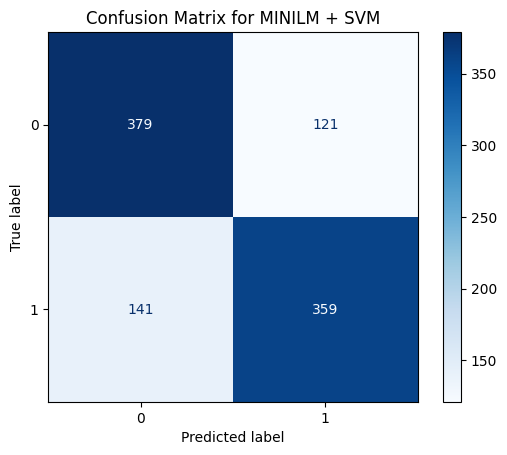

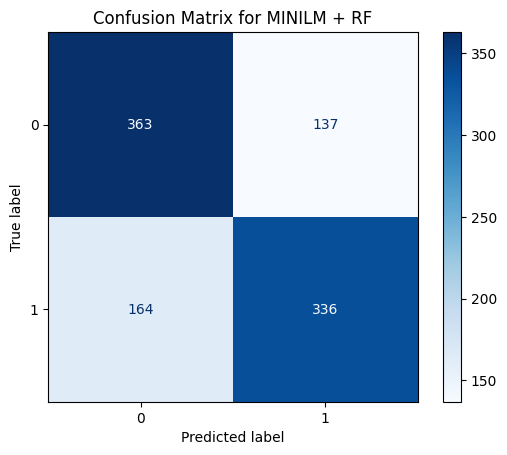

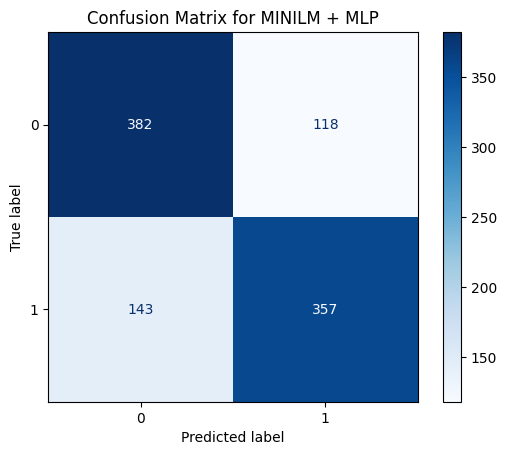

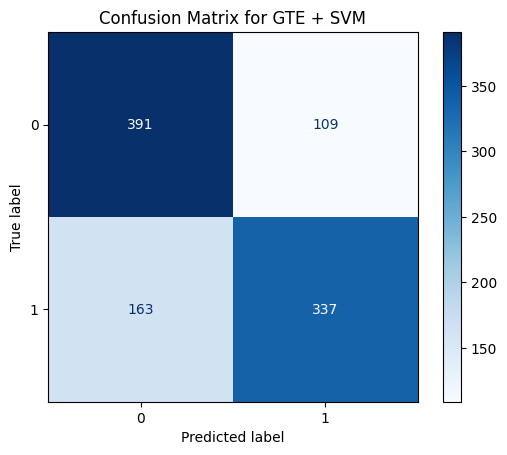

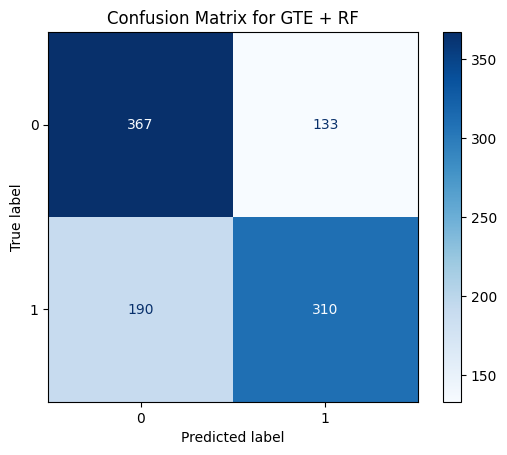

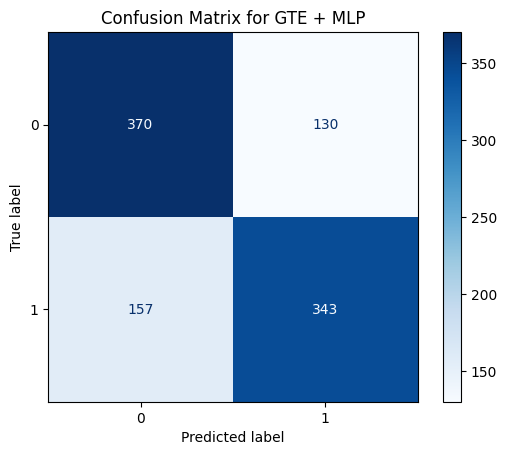

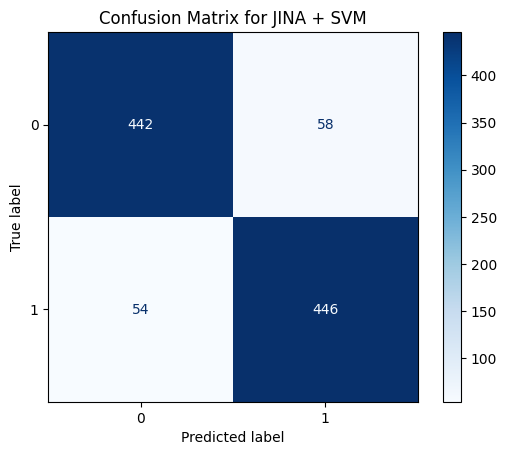

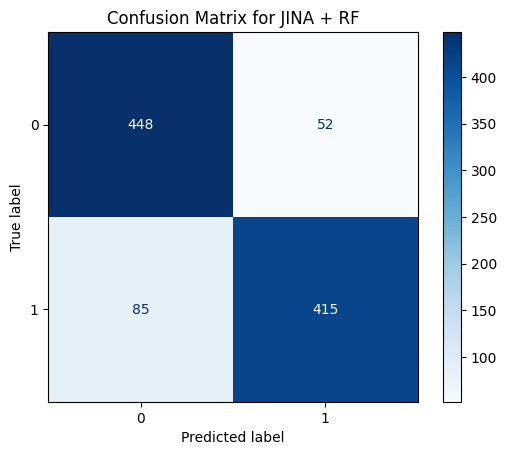

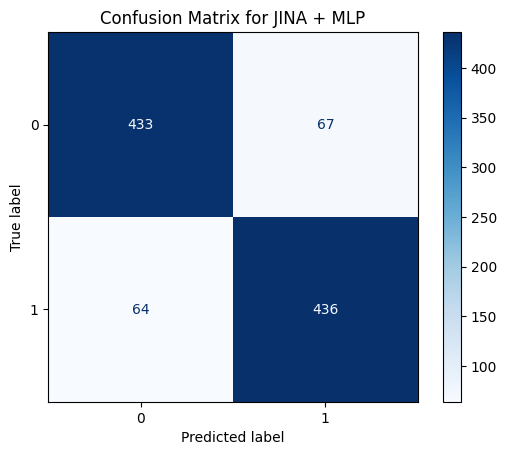

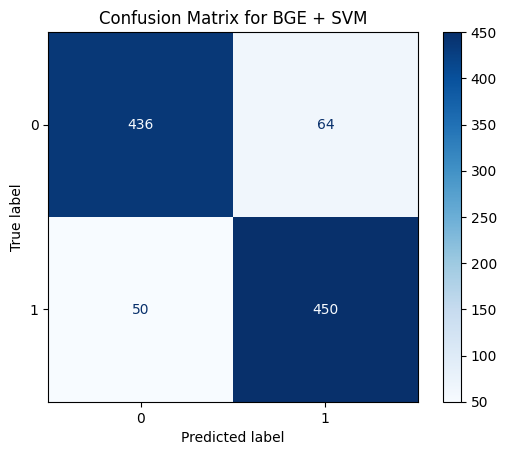

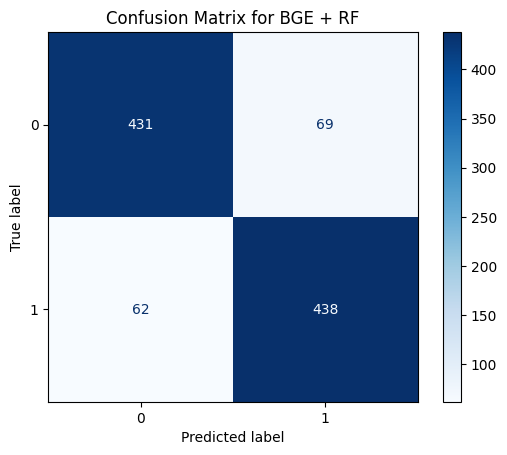

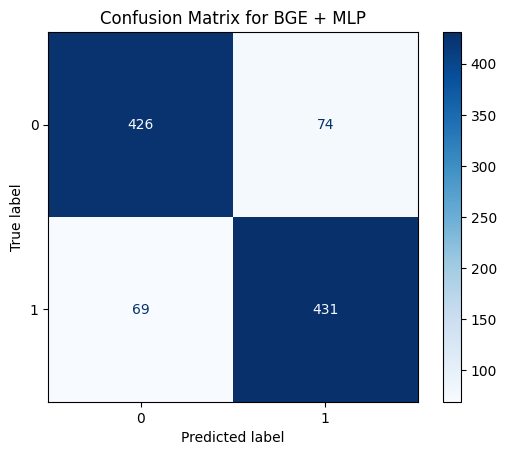

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for model_key, model_name in embedding_models.items():
    for clf_name in classifiers.keys():
        y_true = test_df['sentiment']
        y_pred = all_predictions[model_key][clf_name]

        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix for {model_key.upper()} + {clf_name}")
        plt.show()
